In [5]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
def react_sim(rib_num=1,tRNA_cog=1,repeatAllowed=True,bias=1):
    import numpy as np

    #arbitrarily pick rib_id = 0 as cognate ribosome
    #arbitrarily pick tRNA ids 0 to N as cognate tRNAs
    tRNA_id=np.arange(42)
    
    elong_times = list()
    cog_bind=False;
    sys_t=0
    rxns=0
    
    p_cogRib=[bias*1/42]*tRNA_cog
    p_cogRib=np.concatenate((p_cogRib,[1/42]*(42-tRNA_cog)))
    p_cogRib = p_cogRib/sum(p_cogRib)
    
    p_noncogRib=[1/(42*bias)]*tRNA_cog 
    p_noncogRib=np.concatenate((p_noncogRib,[1/42]*(42-tRNA_cog)))
    p_noncogRib=p_noncogRib/sum(p_noncogRib)
    
    ## Randomly pick tRNA to be bound to all ribosomes from all possible tRNA.
    ##Pick tRNA for cognate ribosome
    tRNA_bound=np.random.choice(tRNA_id,1,replace=False,p=p_cogRib)
    tRNA_unbound = [tRNA for tRNA in tRNA_id if tRNA not in tRNA_bound]

    ##Pick tRNA for any other ribosomes (that must be noncognate)
    if rib_num>1:
        tRNA_bound=np.concatenate((tRNA_bound,np.random.choice(tRNA_unbound,rib_num-1,replace=False,p=p_noncogRib[tRNA_unbound]/sum(p_noncogRib[tRNA_unbound]))))
        tRNA_unbound = [tRNA for tRNA in tRNA_id if tRNA not in tRNA_bound]


    
    ## For each ribosome, now with a reacting tRNA, pick an exponential random time until dissociation
    react_time = np.random.exponential(1000/717,rib_num)
    
    ## Dealing with the case of cog tRNA binding to cog ribosome: still a probability that the tRNA unbinds
    if tRNA_bound[0] in np.arange(tRNA_cog) and np.random.uniform(0,1)<1475/(1475+717):
        cog_bind=True
        sys_t+=np.random.exponential(1000/1475)
        return sys_t,rxns
        
    #### Loop while cognate tRNA isn't bound to cognate ribosome successfully
    while not cog_bind:
        ###Find next event (a tRNA unbinding from a ribosome) and jump the system to this time
        next_rib_time = min(react_time)
        next_rib = np.argmin(react_time)
        just_unbound_tRNA = tRNA_bound[next_rib]

        if(next_rib==0):
            rxns+=1
        ##Adjust all pending reaction times by change in system time
        sys_t+= next_rib_time
        react_time = react_time - np.ones(rib_num)*next_rib_time
        
        ##Pick new tRNA to be bound to recently unbound ribosome
        unbound_tRNA_repeattransient = np.concatenate((tRNA_unbound,[just_unbound_tRNA]))
        #print(p)
        #print(unbound_tRNA_repeattransient)
        #print(p[unbound_tRNA_repeattransient])
        #print(np.random.choice(unbound_tRNA_repeattransient,size=1,replace=False,p=p[unbound_tRNA_repeattransient]))

        if repeatAllowed:
            #Need to increase the probability that the cognate will be picked if next_rib=0 here.
            #currently its a random.choice; maybe change to a probability matrix of picking
            #from tRNA_id, and then shift up tRNA_cog by 2x, and all other 41 down by (1/41)/41.
            if next_rib==0:
                next_tRNA = np.random.choice(unbound_tRNA_repeattransient,size=1,replace=False,p=p_cogRib[unbound_tRNA_repeattransient]/sum(p_cogRib[unbound_tRNA_repeattransient]))
            else:
                next_tRNA = np.random.choice(unbound_tRNA_repeattransient,size=1,replace=False,p=p_noncogRib[unbound_tRNA_repeattransient]/sum(p_noncogRib[unbound_tRNA_repeattransient]))
 
        else:
            if next_rib==0:
                next_tRNA = np.random.choice(tRNA_unbound,size=1,replace=False,p=p_cogRib[tRNA_unbound]/sum(p_cogRib[tRNA_unbound]))
            else:
                next_tRNA = np.random.choice(tRNA_unbound,size=1,replace=False,p=p_noncogRib[tRNA_unbound]/sum(p_noncogRib[tRNA_unbound]))


        tRNA_bound[next_rib] = next_tRNA
        tRNA_unbound = [tRNA for tRNA in tRNA_id if tRNA not in tRNA_bound]
        
            
        ##Pick a reaction time for the newly bound tRNA
        react_time[next_rib] = np.random.exponential(1000/717)

        
        ##If tRNA that's newly bound is a cog tRNA and its bound at the cognate ribosome, see if the cog_binding is successful
        if tRNA_bound[0] in np.arange(tRNA_cog) and next_rib==0:
            if np.random.uniform(0,1)<1475/(1475+717):
                sys_t+=np.random.exponential(1000/1475)
                return sys_t,rxns
                
    return sys_t,rxns

In [6]:
#Sanity check with 1 ribosome and 42 tRNA cog:
#sim_time = 1.358 = 0.673*(0.678)+0.327(1.4)+0.327(0.673*(0.678)+0.327(1.4))+0.327^2(0.673*(0.678)+0.327(1.4))+0.327^3(0.673*(0.678)+0.327(1.4))+0.327^4(0.673*(0.678)+0.327(1.4))+0.327^5(0.673*(0.678)+0.327(1.4))+0.327^6(0.673*(0.678)+0.327(1.4))=
#reactions: 0.47=0.32+0.32^2+0.32^3+0.32^4+0.32^5+0.32^6+0.32^7+0.32^8+0.32^9

sim_times=list()
rxn_count = list()
for i in range(1000):
    rxn = react_sim(rib_num=1,tRNA_cog=42,bias=1)
    sim_times.append(rxn[0])
    rxn_count.append(rxn[1])
print(np.average(sim_times))
print(np.average(rxn_count))

###Sanity check with 40 ribosomes 1 cognate tRNA:
sim_times=list()
rxn_count = list()
for i in range(100):
    rxn = react_sim(rib_num=40,tRNA_cog=1,bias=2)
    sim_times.append(rxn[0])
    rxn_count.append(rxn[1])
print(np.average(sim_times))
print(np.average(rxn_count))

1.3899462928149255
0.499
37.678689315663576
26.48


In [7]:
##gr3
weight = np.array([1.83017716e-01, 2.26910857e-01, 2.06006407e-01, 1.62235994e-01,
 1.09319563e-01, 6.31589405e-02, 3.06503745e-02, 1.22125469e-02,
 4.60216889e-03, 1.35708695e-03, 4.08879048e-04, 9.43163479e-05,
 2.51491044e-05, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
 0.00000000e+00, 0.00000000e+00])

sim_time_all = list()

for num_rib in [4]:#4,8,9,9,8,7
    sim_time_gr = list()
    rxn_count_gr = list()
    for num_tRNA in np.arange(1,7):
        sim_times=list()
        rxn_count = list()
        for i in range(1000):
            rxn = react_sim(rib_num=num_rib,tRNA_cog=num_tRNA,repeatAllowed=False,bias=1)
            sim_times.append(rxn[0])
            rxn_count.append(rxn[1])
        sim_time_gr.append(np.average(sim_times))
        rxn_count_gr.append(np.average(rxn_count))
    print(sim_time_gr)
    print(sim_time_gr*weight[1:len(sim_time_gr)+1]/(1-weight[0]))
    print(np.sum(sim_time_gr*weight[1:len(sim_time_gr)+1]/(1-weight[0])))
    sim_time_all.append(np.sum(sim_time_gr*weight[1:len(sim_time_gr)+1]/(1-weight[0])))
print("Simtimes:")
print(sim_time_all)
#Need to scale each by proper weight now
#Note, double tRNA gives actually double the speed this time, since no effects of space.

[86.81913626447457, 42.53642120722169, 27.587938068600664, 21.889081758282607, 16.42621628189595, 13.73767391790326]
[24.11338042 10.72578374  5.47840099  2.92895562  1.26987138  0.51539043]
45.03178258354701
Simtimes:
[45.03178258354701]


In [8]:
##gr3
weight = np.array([1.83017716e-01, 2.26910857e-01, 2.06006407e-01, 1.62235994e-01,
 1.09319563e-01, 6.31589405e-02, 3.06503745e-02, 1.22125469e-02,
 4.60216889e-03, 1.35708695e-03, 4.08879048e-04, 9.43163479e-05,
 2.51491044e-05, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
 0.00000000e+00, 0.00000000e+00])

sim_time_all = list()

for num_rib in [4]:#4,8,9,9,8,7
    sim_time_gr = list()
    rxn_count_gr = list()
    for num_tRNA in np.arange(1,7):
        sim_times=list()
        rxn_count = list()
        for i in range(1000):
            rxn = react_sim(rib_num=num_rib,tRNA_cog=num_tRNA,repeatAllowed=False,bias=1.1)
            sim_times.append(rxn[0])
            rxn_count.append(rxn[1])
        sim_time_gr.append(np.average(sim_times))
        rxn_count_gr.append(np.average(rxn_count))
    print(sim_time_gr)
    print(sim_time_gr*weight[1:len(sim_time_gr)+1]/(1-weight[0]))
    print(np.sum(sim_time_gr*weight[1:len(sim_time_gr)+1]/(1-weight[0])))
    sim_time_all.append(np.sum(sim_time_gr*weight[1:len(sim_time_gr)+1]/(1-weight[0])))
print("Simtimes:")
print(sim_time_all)
#Need to scale each by proper weight now
#Note, double tRNA gives actually double the speed this time, since no effects of space.

[78.32570613431648, 39.49103298230899, 24.343193002571905, 18.33440471552579, 14.463899391800547, 12.92992363138055]
[21.75439229  9.95787298  4.8340609   2.45330792  1.11816936  0.48508641]
40.60288987293061
Simtimes:
[40.60288987293061]


86.68871123197135
1.7666032007762373
1.0514674606787326
jo 82.44545311560373
49.07084465480462


Text(0, 0.5, 'Elongation time (ms)')

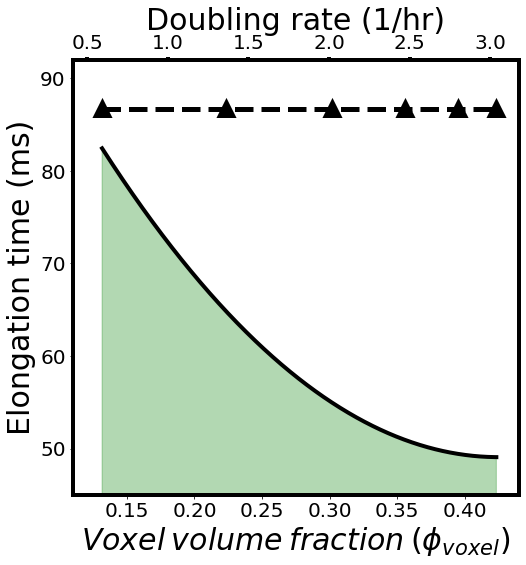

In [15]:
fig, ax = plt.subplots(1,1,figsize=(8,8))

x=np.array([0.13172292, 0.22350473, 0.30181037, 0.35583449, 0.3945994 ,
       0.42317604])
y_model,SS_err,_,_,_ = np.polyfit(x,[1000/12,1000/16,1000/18,1000/19,1000/20,1000/21],2,full=True)
y_hat = np.polyval(y_model,x)
x_sweep_i = np.linspace(min(x),max(x),1000)
y_hat_sweep_i = np.polyval(y_model, x_sweep_i)
ax.plot(x_sweep_i,y_hat_sweep_i,marker='o',markersize=0,markeredgewidth=5,markevery=199,linewidth=4,color='black')
ax.fill_between(x_sweep_i, y_hat_sweep_i, 0*y_hat_sweep_i, color='green',alpha=0.3)


ax.plot(x,np.array([45,45,45,45,45,45]+np.array([1000/1529+1000/209+1000/200+1000/32])),marker='^',markersize=12,markeredgewidth=5,linewidth=5,color='black',linestyle='dashed',label='Rodnina kinetic parameters')
print((45+1000/1529+1000/209+1000/200+1000/32))
print((45+1000/1529+1000/209+1000/200+1000/32)/y_hat_sweep_i[-1])
print((45+1000/1529+1000/209+1000/200+1000/32)/y_hat_sweep_i[0])
print('jo',y_hat_sweep_i[0])

print(y_hat_sweep_i[-1])


82.44545311560373

ax1 = ax.twiny()
ax1.set_xlim(0.41,3.18)
ax1.tick_params(axis='both', which='major',width=4, labelsize=20)
x=[0.6,1.0,1.5,2.0,2.5,3.0]
y_model,SS_err,_,_,_ = np.polyfit([0.6,1.0,1.5,2.0,2.5,3.0],[1000/12,1000/16,1000/18,1000/19,1000/20,1000/21],2,full=True)
y_hat = np.polyval(y_model,x)
x_sweep_i = np.linspace(min(x),max(x),1000)
ax1.set_xlabel('Doubling rate (1/hr)',size=30,color='black')
ax1.set_xticks(np.arange(0.5, 3.1, 0.5))
ax.set_ylim(45,92)

ax.spines['left'].set_linewidth(4)
ax.spines['bottom'].set_linewidth(4)
ax.spines['top'].set_linewidth(4)
ax.spines['right'].set_linewidth(4)
ax.tick_params(axis='both', which='major', labelsize=20)
ax.set_xlim(0.11,0.44)
ax.set_xlabel('$Voxel\: volume\: fraction\:(\phi_{voxel})$',size=30,color='black')
ax.set_ylabel('Elongation time (ms)',size=30,color='black')

86.68871123197135
1.7666032007762373
1.0514674606787326
jo 82.44545311560373
49.07084465480462


Text(0, 0.5, 'Elongation time (ms)')

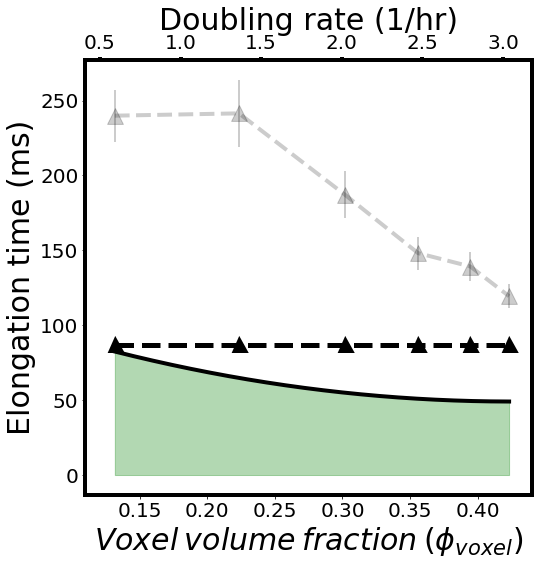

In [14]:
fig, ax = plt.subplots(1,1,figsize=(8,8))

x=np.array([0.13172292, 0.22350473, 0.30181037, 0.35583449, 0.3945994 ,
       0.42317604])
y_model,SS_err,_,_,_ = np.polyfit(x,[1000/12,1000/16,1000/18,1000/19,1000/20,1000/21],2,full=True)
y_hat = np.polyval(y_model,x)
x_sweep_i = np.linspace(min(x),max(x),1000)
y_hat_sweep_i = np.polyval(y_model, x_sweep_i)
ax.plot(x_sweep_i,y_hat_sweep_i,marker='o',markersize=0,markeredgewidth=5,markevery=199,linewidth=4,color='black')
ax.fill_between(x_sweep_i, y_hat_sweep_i, 0*y_hat_sweep_i, color='green',alpha=0.3)


ax.plot(x,np.array([45,45,45,45,45,45]+np.array([1000/1529+1000/209+1000/200+1000/32])),marker='^',markersize=9,markeredgewidth=5,linewidth=5,color='black',linestyle='dashed',label='Rodnina kinetic parameters')
print((45+1000/1529+1000/209+1000/200+1000/32))
print((45+1000/1529+1000/209+1000/200+1000/32)/y_hat_sweep_i[-1])
print((45+1000/1529+1000/209+1000/200+1000/32)/y_hat_sweep_i[0])
print('jo',y_hat_sweep_i[0])
print(y_hat_sweep_i[-1])

elong=[239.88674068169692, 241.42409855440323, 187.13517313099993, 148.14840265729532, 139.19060671943387, 119.3619294273278]
elong_sem=[17.399542168328775, 22.480177574005303, 15.617422862800295, 11.075063764231855, 9.7193569475753, 7.85688899238707]


ax.scatter(x,elong,zorder=2,s=250,marker='^',color='black',alpha=0.2)
ax.errorbar(x,elong,elong_sem,zorder=1,linewidth=4,elinewidth=2,linestyle='dashed',color='black',alpha=0.2)

ax1 = ax.twiny()
ax1.set_xlim(0.41,3.18)
ax1.tick_params(axis='both', which='major',width=4, labelsize=20)
x=[0.6,1.0,1.5,2.0,2.5,3.0]
y_model,SS_err,_,_,_ = np.polyfit([0.6,1.0,1.5,2.0,2.5,3.0],[1000/12,1000/16,1000/18,1000/19,1000/20,1000/21],2,full=True)
y_hat = np.polyval(y_model,x)
x_sweep_i = np.linspace(min(x),max(x),1000)
ax1.set_xlabel('Doubling rate (1/hr)',size=30,color='black')
ax1.set_xticks(np.arange(0.5, 3.1, 0.5))
#ax.set_ylim(45,90)

ax.spines['left'].set_linewidth(4)
ax.spines['bottom'].set_linewidth(4)
ax.spines['top'].set_linewidth(4)
ax.spines['right'].set_linewidth(4)
ax.tick_params(axis='both', which='major', labelsize=20)
ax.set_xlim(0.11,0.44)
ax.set_xlabel('$Voxel\: volume\: fraction\:(\phi_{voxel})$',size=30,color='black')
ax.set_ylabel('Elongation time (ms)',size=30,color='black')

In [16]:
elong_empir = [82.44545311560373, 64.80173984744593, 54.953890127858514, 50.92539189171946, 49.42689484353585, 49.07084465480462]
print(np.divide(elong,[45,45,45,45,45,45]+np.array([1000/1529+1000/209+1000/200+1000/32])))
print(np.divide([45,45,45,45,45,45]+np.array([1000/1529+1000/209+1000/200+1000/32]),elong_empir))
print(np.divide(elong,elong_empir))

[2.76722006 2.78495429 2.15870291 1.70896995 1.60563705 1.3769028 ]
[1.05146746 1.33775284 1.57748088 1.70226891 1.75387735 1.7666032 ]
[2.90964185 3.7255805  3.40531258 2.90912641 2.81609045 2.4324409 ]


array([2.76722006, 2.78495429, 2.15870291, 1.70896995, 1.60563705,
       1.3769028 ])

Text(0.5, 1.0, 'Simulations with instant self-mixing &\n ~3x cognate tRNA bias')

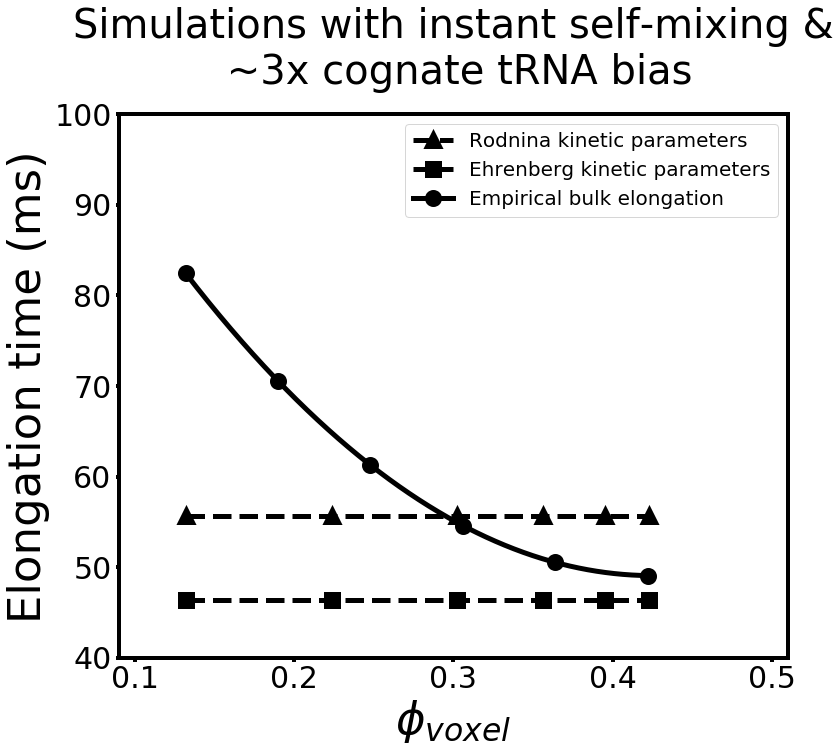

In [515]:
fig, ax = plt.subplots(1,1,figsize=(12,10))
x=[0.132,0.224,0.302,0.356,0.395,0.423]
y_model,SS_err,_,_,_ = np.polyfit(x,[1000/12,1000/16,1000/18,1000/19,1000/20,1000/21],2,full=True)
y_hat = np.polyval(y_model,x)
x_sweep_i = np.linspace(min(x),max(x),1000)
y_hat_sweep_i = np.polyval(y_model, x_sweep_i)
ax.plot(x,np.array([14,14,14,14,14,14]+np.array([1000/1529+1000/209+1000/200+1000/32])),marker='^',markersize=12,markeredgewidth=5,linewidth=5,color='black',linestyle='dashed',label='Rodnina kinetic parameters')
ax.plot(x,np.array([14/3,14/3,14/3,14/3,14/3,14/3]+np.array([1000/1529+1000/209+1000/200+1000/32])),marker='s',markersize=12,markeredgewidth=5,linewidth=5,color='black',linestyle='dashed',label='Ehrenberg kinetic parameters')
ax.plot(x_sweep_i,y_hat_sweep_i,marker='o',markersize=12,markeredgewidth=5,markevery=199,linewidth=5,color='black',label='Empirical bulk elongation')

ax.tick_params(axis='both', which='major',width=4, labelsize=30)
ax.set_xlim(0.09,0.51)
ax.set_ylim(40,100)
ax.spines['left'].set_linewidth(4)
ax.spines['bottom'].set_linewidth(4)
ax.spines['top'].set_linewidth(4)
ax.spines['right'].set_linewidth(4)
ax.set_xlabel('$\phi_{voxel}$',size=45,color='black')
ax.set_ylabel('Elongation time (ms)',size=45,color='black')
ax.legend()
ax.legend( prop={'size': 20})
plt.title('Simulations with instant self-mixing &\n ~3x cognate tRNA bias',size=40,pad=30)

#Super-physical simulations

#show with 6 tRNA, 5 tRNA, 4 tRNA; calculate how much bias this is

In [100]:
tRNA_cog=42
p=[1/42*tRNA_cog]
p=np.concatenate((p,[(1-1/42*tRNA_cog)/41]*41))
print(p)
print(np.random.choice(p,size=1,replace=False,p=p))

[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[1.]
